In [65]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.patches import Patch
import numpy as np

pd.options.mode.chained_assignment = None  # default='warn'
# 設置微軟正黑體為全域字體
rcParams['font.family'] = 'Microsoft JhengHei'
battery_kWh = 522
battery_kw = 250

In [125]:
# 讀取 Excel 檔案
file_path = "meter_02293584018_data.xlsx"  # 請替換成你的檔案路徑
data = pd.read_excel(file_path)

# 將時間欄位轉換為日期時間格式
data['時間'] = pd.to_datetime(data['時間'])

# 篩選需要的時間段和欄位
start_time = "15:30:00"
end_time = "21:30:00"
filtered_data = data[(data['時間'].dt.time >= pd.to_datetime(start_time).time())
                     & (data['時間'].dt.time <= pd.to_datetime(end_time).time())]

# 計算用電總量
columns_to_sum = ['尖峰', '半尖峰', '週六半尖峰', '離峰']
filtered_data[columns_to_sum] = filtered_data[columns_to_sum] * 0.25
filtered_data['用電總量'] = filtered_data[columns_to_sum].sum(axis=1)

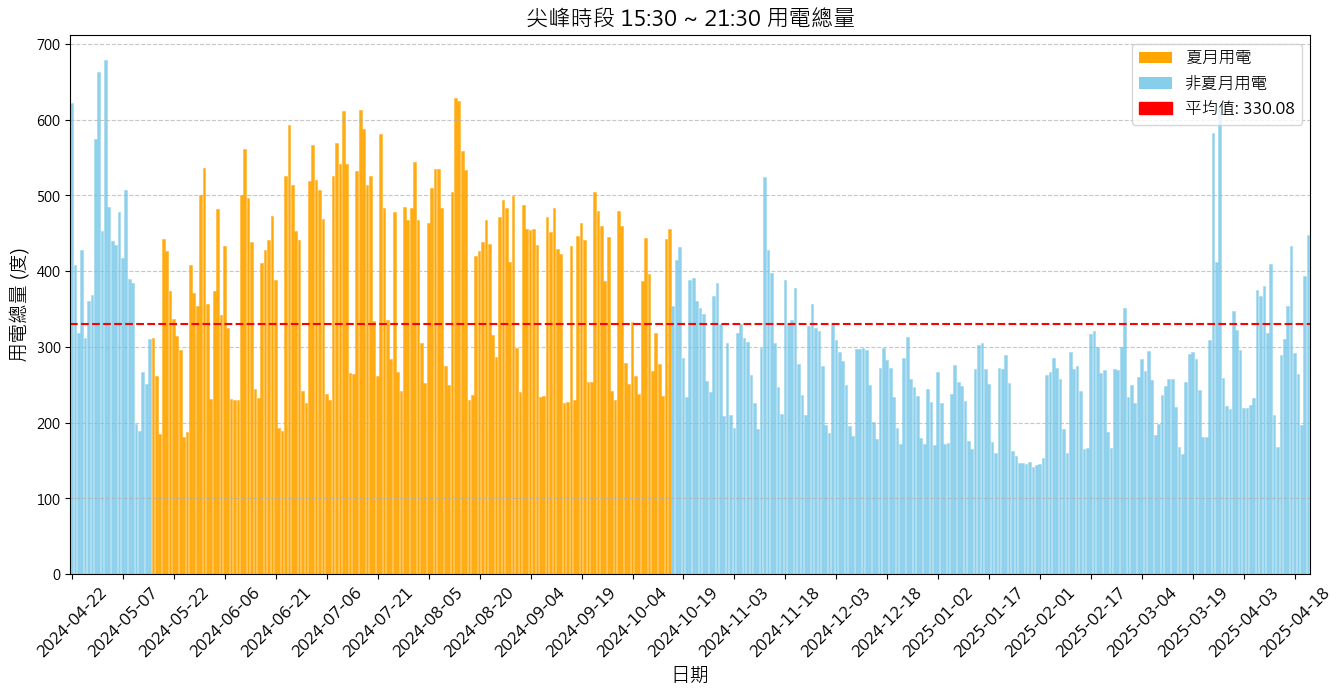

In [129]:
# 按日期統計用電總量
daily_summary = filtered_data.groupby(
    filtered_data['時間'].dt.date)['用電總量'].sum()

average_power = daily_summary.mean()

# 設置顏色：夏季（6月16日到10月15日）為橘色，其他為天藍色
colors = [
    'orange' if (date.month > 5 or (date.month == 5 and date.day >= 16)) and
    (date.month < 10 or (date.month == 10 and date.day <= 15)) else 'skyblue'
    for date in daily_summary.index
]

# 繪製柱狀圖
daily_summary.plot(kind='bar',
                   figsize=(16, 7),
                   color=colors,
                   edgecolor=colors,
                   linewidth=1.2,
                   alpha=0.8)

# 設置平均線
plt.axhline(y=average_power, color='red', linestyle='--')

# 設置 X 軸的顯示間隔
x_labels = daily_summary.index
plt.xticks(range(0, len(x_labels), 15),
           x_labels[::15],
           rotation=45,
           fontsize=12)

# 圖表設置
plt.title('尖峰時段 15:30 ~ 21:30 用電總量', fontsize=16)
plt.xlabel('日期', fontsize=14)
plt.ylabel('用電總量 (度)', fontsize=14)
plt.xticks(rotation=45, fontsize=12)  # 日期旋轉以便於閱讀

legend_elements = [
    Patch(facecolor='orange', label='夏月用電'),
    Patch(facecolor='skyblue', label='非夏月用電'),
    Patch(color='red', label=f'平均值: {average_power:.2f}')
]
plt.legend(handles=legend_elements, fontsize=12, loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)


In [144]:
filtered_data['日期'] = filtered_data['時間'].dt.date
filtered_data['小時'] = filtered_data['時間'].dt.hour

hour_summary = filtered_data.groupby(['日期', '小時'])['用電總量'].sum()
hour_summary = hour_summary.reset_index()
hour_summary['電池放電量'] = np.zeros(len(hour_summary))

daily_summary = hour_summary.groupby('日期')
last_index = 0
for daily_data in daily_summary:
    dataframe = daily_data[1]
    current_battery = battery_kWh
    last_round_battery = 0
    while (last_round_battery != current_battery):
        usage_average = dataframe['用電總量'].mean()
        last_round_battery = current_battery
        for i in range(last_index, last_index + len(dataframe)):
            higher_usage = dataframe['用電總量'][i] - usage_average
            if higher_usage > 0 and higher_usage < current_battery and dataframe.loc[
                    i, '電池放電量'] < battery_kw:
                dataframe.loc[i, '用電總量'] = usage_average
                dataframe.loc[i,
                              '電池放電量'] = dataframe.loc[i,
                                                       '電池放電量'] + higher_usage
                current_battery -= higher_usage
            elif higher_usage > 0 and higher_usage >= current_battery and dataframe.loc[
                    i, '電池放電量'] < battery_kw:
                dataframe.loc[i,
                              '用電總量'] = dataframe.loc[i,
                                                      '用電總量'] - current_battery
                dataframe.loc[
                    i, '電池放電量'] = dataframe.loc[i, '電池放電量'] + current_battery
                current_battery = 0
    if (current_battery > 0):
        distribute_battery = current_battery / (dataframe['電池放電量']
                                                < battery_kw).sum()
        for i in range(last_index, last_index + len(dataframe)):
            if dataframe.loc[i, '電池放電量'] < battery_kw and dataframe.loc[
                    i, '用電總量'] > distribute_battery:
                dataframe.loc[
                    i, '用電總量'] = dataframe.loc[i, '用電總量'] - distribute_battery
                dataframe.loc[
                    i,
                    '電池放電量'] = dataframe.loc[i, '電池放電量'] + distribute_battery
                current_battery -= distribute_battery
            elif dataframe.loc[i, '電池放電量'] < battery_kw and dataframe.loc[
                    i, '用電總量'] <= distribute_battery:
                current_battery -= dataframe.loc[i, '用電總量']
                dataframe.loc[i, '電池放電量'] = dataframe.loc[
                    i, '電池放電量'] + dataframe.loc[i, '用電總量']
                dataframe.loc[i, '用電總量'] = 0
    print(daily_data[0])
    last_index += len(dataframe)

2024-04-22
2024-04-23
2024-04-24
2024-04-25
2024-04-26
2024-04-27
2024-04-28
2024-04-29
2024-04-30
2024-05-01
2024-05-02


KeyboardInterrupt: 